In [1]:
!pip install pandas numpy tensorflow keras sklearn matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [1]:
import pandas as pd

train = pd.read_csv('../Deep-Learning-project/dataset/training.csv')
test = pd.read_csv('../Deep-Learning-project/dataset/test.csv')
validation = pd.read_csv('../Deep-Learning-project/dataset/validation.csv')

In [2]:
!pip install nltk

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokenized = word_tokenize(text)  # tokenize text
    cleaned_text = [word for word in tokenized if word not in stopwords.words('english')]  # remove stopwords
    return " ".join(cleaned_text)

[nltk_data] Downloading package stopwords to C:\Users\ABHISHEK
[nltk_data]     DEORE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ABHISHEK
[nltk_data]     DEORE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Assuming the preprocessing function is defined above
train['cleaned_text'] = train['text'].apply(preprocess_text)
test['cleaned_text'] = test['text'].apply(preprocess_text)
validation['cleaned_text'] = validation['text'].apply(preprocess_text)

labels_dict = {0:'sad', 1:'happy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['emotion'] = train['label'].map(labels_dict)
test['emotion'] = test['label'].map(labels_dict)
validation['emotion'] = validation['label'].map(labels_dict)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])

X_train = tokenizer.texts_to_sequences(train['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_val = tokenizer.texts_to_sequences(validation['cleaned_text'])

# Pad sequences
max_length = max(max(len(x) for x in X_train), max(len(x) for x in X_test), max(len(x) for x in X_val))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

# Encode labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['emotion'])

y_train = encoder.transform(train['emotion'])
y_test = encoder.transform(test['emotion'])
y_val = encoder.transform(validation['emotion'])

In [6]:
test.head()

,text,label,cleaned_text,emotion
0,im feeling rather rotten so im not very ambiti...,0,im feeling rather rotten im ambitious right,sad
1,im updating my blog because i feel shitty,0,im updating blog feel shitty,sad
2,i never make her separate from me because i do...,0,never make separate ever want feel like ashamed,sad
3,i left with my bouquet of red and yellow tulip...,1,left bouquet red yellow tulips arm feeling sli...,happy
4,i was feeling a little vain when i did this one,0,feeling little vain one,sad


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

vocab_size = len(tokenizer.word_index) + 1  # Plus 1 for padding

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(SimpleRNN(256, return_sequences=False))
model.add(Dense(6, activation='softmax'))  # 6 for the number of emotion categories

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)

Epoch 1/10
125/125 [==============================] - 10s 65ms/step - loss: 1.5160 - accuracy: 0.4046 - val_loss: 1.3769 - val_accuracy: 0.5205
Epoch 2/10
125/125 [==============================] - 7s 56ms/step - loss: 1.2767 - accuracy: 0.5469 - val_loss: 1.2327 - val_accuracy: 0.5490
Epoch 3/10
125/125 [==============================] - 7s 55ms/step - loss: 1.0498 - accuracy: 0.6123 - val_loss: 1.1537 - val_accuracy: 0.6025
Epoch 4/10
125/125 [==============================] - 7s 54ms/step - loss: 0.8291 - accuracy: 0.7138 - val_loss: 1.0511 - val_accuracy: 0.6735
Epoch 5/10
125/125 [==============================] - 7s 55ms/step - loss: 0.6099 - accuracy: 0.7919 - val_loss: 0.9617 - val_accuracy: 0.6910
Epoch 6/10
125/125 [==============================] - 7s 55ms/step - loss: 0.4687 - accuracy: 0.8438 - val_loss: 1.1356 - val_accuracy: 0.6750
Epoch 7/10
125/125 [==============================] - 7s 55ms/step - loss: 0.3963 - accuracy: 0.8712 - val_loss: 1.1029 - val_accuracy: 0.688

In [9]:
!pip install pydot
!pip install graphviz

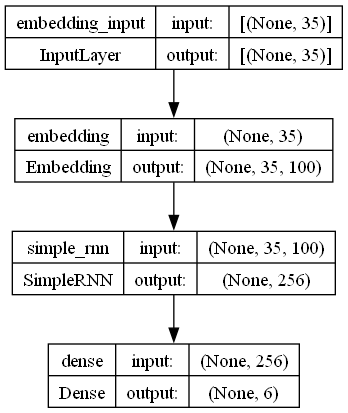

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [11]:
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
    print(f'Epoch {epoch+1}: Loss = {loss}, Accuracy = {acc}')

Epoch 1: Loss = 1.5159908533096313, Accuracy = 0.4046249985694885
Epoch 2: Loss = 1.2767475843429565, Accuracy = 0.546875
Epoch 3: Loss = 1.0497987270355225, Accuracy = 0.6123124957084656
Epoch 4: Loss = 0.8291193842887878, Accuracy = 0.7138124704360962
Epoch 5: Loss = 0.6098875999450684, Accuracy = 0.7919374704360962
Epoch 6: Loss = 0.4687057435512543, Accuracy = 0.84375
Epoch 7: Loss = 0.3962903618812561, Accuracy = 0.8711875081062317
Epoch 8: Loss = 0.30988654494285583, Accuracy = 0.9013124704360962
Epoch 9: Loss = 0.26550325751304626, Accuracy = 0.9161249995231628
Epoch 10: Loss = 0.21559211611747742, Accuracy = 0.9366875290870667


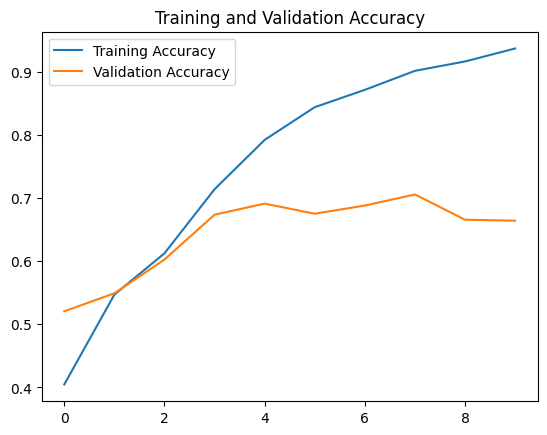

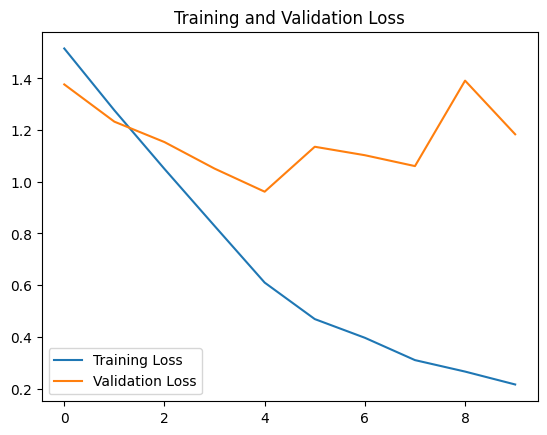

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
def predict_emotion(text):
    # Preprocess and tokenize the input text
    seq = tokenizer.texts_to_sequences([preprocess_text(text)])
    # Pad the sequence
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    # Perform the prediction
    prediction = model.predict(padded_seq)
    # Decode the prediction
    label_idx = prediction.argmax(axis=1)[0]
    return encoder.inverse_transform([label_idx])[0]

# Example usage
input_text = input("Enter some sentence:")
predict_emotion(input_text)


Enter some sentence:i love deep learning
1/1 [==============================] - 0s 283ms/step


'fear'

In [14]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Predict probabilities for the validation set
probabilities = model.predict(X_val)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Assuming y_val is already the array of labels and not one-hot encoded
print(accuracy_score(y_val, predictions))
print(classification_report(y_val, predictions))


63/63 [==============================] - 1s 12ms/step
0.664
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       275
           1       0.43      0.52      0.47       212
           2       0.84      0.68      0.75       704
           3       0.61      0.57      0.59       178
           4       0.69      0.80      0.74       550
           5       0.23      0.32      0.27        81

    accuracy                           0.66      2000
   macro avg       0.58      0.59      0.58      2000
weighted avg       0.69      0.66      0.67      2000



In [15]:
# Tokenize the test text data
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Encode the labels if they are categorical
y_test = encoder.transform(test['emotion'])

# Predict probabilities for the test set
probabilities = model.predict(X_test)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Evaluate the performance of the LSTM model on the test set
test_accuracy = accuracy_score(y_test, predictions)*100
test_report = classification_report(y_test, predictions)

print("Test Accuracy:", test_accuracy)
print("Classification Report on Test Data:\n", test_report)


63/63 [==============================] - 0s 6ms/step
Test Accuracy: 65.9
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67       275
           1       0.50      0.60      0.55       224
           2       0.79      0.65      0.71       695
           3       0.50      0.57      0.53       159
           4       0.74      0.76      0.75       581
           5       0.17      0.29      0.21        66

    accuracy                           0.66      2000
   macro avg       0.56      0.59      0.57      2000
weighted avg       0.68      0.66      0.67      2000

